![Python Logo](../../assets/images/python-logo-master-v3-TM.png)

# <center> Exploratory Data Analysis for StackOverflow User Data </center>
### <center> Shagun Sodhani </center>

In [1]:
# put in the name of the Stack Exchange Site which you want to analyse.
data_source = "StackOverflow"
data_type = "User"
base_url = "http://stackoverflow.com/users/"
local_user_data_path = "../../data/"+data_source+"/"+data_type
use_local_datapath = True
# If this is set to false, dbfs_data_path is used to read the data.
dbfs_user_data_path = ""
# dbfs_data_path is to be used when running the notebook on Databricks and data has been uploaded to dbfs. 
# For more details, refer https://github.com/shagunsodhani/PyCon2016

### Before we dive into the code, lets see the script which I used to run the notebook.

In [2]:
!cat ../../run.sh

PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS="notebook" $SPARK_HOME/bin/pyspark --master local[2]


**PYSPARK_DRIVER_PYTHON=jupyter**

This sets the driver as this Jupyter Notebook

**PYSPARK_DRIVER_PYTHON_OPTS="notebook"**

This is used to pass options when starting the Python driver

**$SPARK_HOME/bin/pyspark --master local[2]**

This runs a pyspark shell in local mode with 2 executors.

## Let us begin

### We will import everything in one cell for the sake for reference.

In [3]:
import pyspark.sql.functions as func
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
import pandas as pd
from time import time
import operator
%matplotlib inline
from __future__ import print_function

### Notice that we did not import sparkContext or sqlContext. They are already created for us to use.

### Check if SparkContext and SQLContext have been created.

In [4]:
if('sc' in locals() or 'sc' in globals()):
    print("SparkContext is defined.")
else:
    print("SparkContext does not exist.")

SparkContext is defined.


In [5]:
if('sqlContext' in locals() or 'sqlContext' in globals()):
    print("SQLContext is defined.")
else:
    print("SQLContext does not exist.")

SQLContext is defined.


### Now let us load the user data as a dataframe. Since we will be using this data more than once, we will cache it in memory.

In [6]:
start_time = time()
print ("data_source =", data_source)
print ("data_type =", data_type)
if(use_local_datapath):
    user_data_path = local_user_data_path
else:
    user_data_path = dbfs_user_data_path
print ("user_data_path =", user_data_path)
user_df = sqlContext.read.load(user_data_path).cache()
print ("Time taken =", time() - start_time, "seconds.")

data_source = StackOverflow
data_type = User
user_data_path = ../../data/StackOverflow/User
Time taken = 20.1194429398 seconds.


### *sqlContext.read.load(user_data_path)* tells the master to load the data written in *user_data_path* as a parquet file (default choice for data format).

### *cache()* tells the master to cache the data in the main memory for faster operations.

## <center> DataFrame </center>

### A DataFrame is a distributed collection of data organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R/Python, but with richer optimizations under the hood.

### Since DataFrame organizes the data into a relational view (rows and columns), it has a schema associated with it.

In [7]:
print("Schema for user dataframe")
user_df.printSchema()

Schema for user dataframe
root
 |-- Id: long (nullable = true)
 |-- Reputation: long (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- DisplayName: string (nullable = true)
 |-- EmailHash: string (nullable = true)
 |-- lastAccessDate: string (nullable = true)
 |-- WebsiteUrl: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- AboutMe: string (nullable = true)
 |-- Views: long (nullable = true)
 |-- UpVotes: long (nullable = true)
 |-- DownVotes: long (nullable = true)
 |-- AccountId: long (nullable = true)



### Some common metrics for this data

In [8]:
number_of_rows = user_df.count()
print("Total number of rows in the data = " + str(number_of_rows))

Total number of rows in the data = 5677258


In [9]:
number_of_unique_ids = user_df.select('Id').distinct().count()
print("Total number of unique Id in the data = " + str(number_of_unique_ids))

Total number of unique Id in the data = 5677258


In [10]:
max_reputation = user_df.agg({"Reputation": "max"}).collect()[0][0]
print("Maximum reputation for a user = " + str(max_reputation))

Maximum reputation for a user = 872346


In [11]:
max_upvotes = user_df.agg({"UpVotes": "max"}).collect()[0][0]
print("Maximum UpVotes for a user = " + str(max_upvotes))

Maximum UpVotes for a user = 155541


### Alternatively, we could use the *describe* method to get all these statistics in one go.

In [12]:
user_df.describe().toPandas()

,summary,Id,Reputation,Age,Views,UpVotes,DownVotes,AccountId
0,count,5677258,5677258,5677258,5677258,5677258,5677258,5677258
1,mean,3458959.329377492,122.36497495798147,2.1128550085270037,14.985955015607887,13.056719106300964,1.5714251492533895,4239436.648318959
2,stddev,1775717.819577991,2178.7325223376183,9.808645948617777,621.4858576805434,157.4016433378767,296.28945574718387,2463450.0689051063
3,min,-1,1,-972,0,0,0,-2
4,max,6455148,872346,96,1190669,155541,683400,8619800


### Disclaimer - Pandas is used only for visualising the processed data in tabular form as Jupyter notebooks visualise Pandas dataframes very nicely. All the processing is being done by Spark.

### Let us find the user who has the highest reputation.

In [13]:
user_max_reputation = user_df.filter("Reputation = "+str(max_reputation)).select('Id').collect()[0][0]
user_df.filter("Reputation = "+str(max_reputation)).toPandas()

,Id,Reputation,CreationDate,DisplayName,EmailHash,lastAccessDate,WebsiteUrl,Location,Age,AboutMe,Views,UpVotes,DownVotes,AccountId
0,22656,872346,2008-09-26T12:05:05.150,Jon Skeet,,2016-06-11T17:54:35.587,http://csharpindepth.com,"Reading, United Kingdom",40,"<p>\nAuthor of <a href=""http://www.manning.com...",1190669,15469,5013,11683


##  <center> Lazy Evaluation </center>

Spark Dataframes and RDDs are lazy. They do nothing unless an action is called. We can keep adding as many transformations as we want but nothing actually happens till we call an action. By deferring evaluations, Spark can optimise the overall workflow as it evaluates only that which is needed and only when it is needed.

In [14]:
start_time = time()
user_max_reputation = user_df.orderBy("Reputation", desc=True)
print (user_max_reputation)
print ("Time taken =", time() - start_time, "seconds.")

DataFrame[Id: bigint, Reputation: bigint, CreationDate: string, DisplayName: string, EmailHash: string, lastAccessDate: string, WebsiteUrl: string, Location: string, Age: bigint, AboutMe: string, Views: bigint, UpVotes: bigint, DownVotes: bigint, AccountId: bigint]
Time taken = 0.0228841304779 seconds.


In [15]:
start_time = time()
# list_user_max_reputation = user_df.orderBy("Reputation", desc=True).collect()
print ("This command crashes.")
# print ("Time taken =", time() - start_time, "seconds.")

This command crashes.


In [16]:
start_time = time()
list_user_max_reputation = user_df.orderBy("Reputation", desc=True).take(1)
print ("Size of list =",len(list_user_max_reputation))
print ("Time taken =", time() - start_time, "seconds.")

Size of list = 1
Time taken = 29.2843821049 seconds.


### Lazy is better than eager.

### We can find the user with maximum number of upvotes, downvotes and views.

In [17]:
start_time = time() 
column_list = ["Reputation", "UpVotes", "DownVotes", "Views", "Age"]

for col in column_list:
    max_value_col = user_df.orderBy(col, ascending=False).select("Id", col).take(1)[0]
    userId = str(max_value_col[0])
    print ("max", col, "value =",str(max_value_col[1]),"for userId =", userId, "", base_url+userId, "\n")
print ("Time taken =", time() - start_time, "seconds.")

max Reputation value = 872346 for userId = 22656  http://stackoverflow.com/users/22656 

max UpVotes value = 155541 for userId = -1  http://stackoverflow.com/users/-1 

max DownVotes value = 683400 for userId = -1  http://stackoverflow.com/users/-1 

max Views value = 1190669 for userId = 22656  http://stackoverflow.com/users/22656 

max Age value = 96 for userId = 4379582  http://stackoverflow.com/users/4379582 

Time taken = 40.7793471813 seconds.


### Interestingly, the user with most repuatation is also the most viewed user. The userId = -1 corresponds to community (bot) user which helps in moderation.

###  Before using any algorithm from Spark Machine Learning (ml and MLlib), we transform this data to a collection of vectors. While parsing the raw xml files, I used certain default values (in place of missing values). We will filter those values now.

In [18]:
filter_expression = "AccountId > -1 and DownVotes > -1 and UpVotes > -1 and \
Views > -1 and Reputation > -9223372036854775808 and Age > 0"
vectorData = user_df.filter(filter_expression)\
.select(column_list)\
.map(lambda data: Vectors.dense([c for c in data]))

### *vectorData* consists of rows, where each row is a vector of data we selected above. 

In [19]:
print (vectorData)
vectorData.take(5)

PythonRDD[118] at RDD at PythonRDD.scala:43


[DenseVector([11.0, 0.0, 0.0, 5.0, 29.0]),
 DenseVector([21.0, 1.0, 0.0, 9.0, 34.0]),
 DenseVector([1.0, 0.0, 0.0, 0.0, 27.0]),
 DenseVector([336.0, 7.0, 1.0, 67.0, 20.0]),
 DenseVector([119.0, 17.0, 0.0, 23.0, 25.0])]

### Calculating basic statistics about the data

In [20]:
print ("Columns in vectorData are",column_list)
stats = Statistics.colStats(vectorData)
for col, val in zip(column_list, stats.mean()):
    print ("Average ", col, " = ", val)

Columns in vectorData are ['Reputation', 'UpVotes', 'DownVotes', 'Views', 'Age']
Average  Reputation  =  657.790010956
Average  UpVotes  =  71.3291876684
Average  DownVotes  =  8.45428023762
Average  Views  =  79.1855292626
Average  Age  =  30.6904020327


Other supported statistics include:
    * count()
    * max()
    * mean()
    * min()
    * normL1()
    * normL2()
    * numNonzeros()
    * variance()

For the sake of completeness, we will try all these methods. We would visualise this data as Pandas dataframe to make it look clean

In [21]:
pd_data = map(list, [[stats.count()]*5, stats.max(), stats.mean(), stats.min(), stats.normL1(), stats.normL2(),\
           stats.numNonzeros() ,stats.variance()])
pd_index = ['Count', 'Max', 'Mean', 'Min', 'NormL1', 'NormL2', 'NumNonzeros', 'Variance']
pd.DataFrame(pd_data, index=pd_index, columns=column_list)

,Reputation,UpVotes,DownVotes,Views,Age
Count,5.576910e+05,557691.000000,557691.000000,557691.000000,557691.000000
Max,8.723460e+05,32254.000000,35993.000000,1190669.000000,96.000000
Mean,6.577900e+02,71.329188,8.454280,79.185529,30.690402
Min,1.000000e+00,0.000000,0.000000,0.000000,6.000000
NormL1,3.668436e+08,39779646.000000,4714876.000000,44161057.000000,17115761.000000
NormL2,4.349657e+06,269943.715556,129143.308685,1417240.092318,23779.951114
NumNonzeros,5.576910e+05,246964.000000,102515.000000,424885.000000,557691.000000
Variance,3.349210e+07,125575.426730,29834.017635,3595317.403220,72.076761


### We will calculate correlation between each pair of columns and see if we find some thing interesting.

In [22]:
start_time = time()
Statistics.colStats(vectorData)
pd_data = Statistics.corr(vectorData, method="pearson")
pd.DataFrame(pd_data, index=column_list, columns=column_list)
print ("Time taken =", time() - start_time, "seconds.")
pd.DataFrame(pd_data, index=column_list, columns=column_list)

Time taken = 14.9935221672 seconds.


,Reputation,UpVotes,DownVotes,Views,Age
Reputation,1.000000,0.568410,0.338779,0.558201,0.060482
UpVotes,0.568410,1.000000,0.328948,0.269376,0.061463
DownVotes,0.338779,0.328948,1.000000,0.222938,0.021307
Views,0.558201,0.269376,0.222938,1.000000,0.021190
Age,0.060482,0.061463,0.021307,0.021190,1.000000


### Some observations:
    High positive correlation between Reputation and Upvotes (0.57).
    
    High positive correlation between Reputation and Views (0.56).

The last observation can be explained by the hypothesis that more reputation you have, more likely it is that people would land up on your profile page. Lets drill down further on the first observation.

We filter the data to contain only Reputation and UpVotes and filter for rows with defualt values

In [23]:
columns_to_select = ["Reputation", "UpVotes"]
data = user_df.filter(filter_expression).select(columns_to_select).cache()
data.sample(False, 0.0001, 42).toPandas()

,Reputation,UpVotes
0,1,0
1,665,61
2,1,0
3,11,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,55,5


Notice that this is the second dataframe that we have cached so far.

We can check the memory profile for the app at http://localhost:4040/storage.

![Python Logo](../../assets/screenshots/storage1.png)

We no longer need the *user_df* dataframe so we will unpersist it and recover some memory.

In [24]:
user_df.unpersist()

DataFrame[Id: bigint, Reputation: bigint, CreationDate: string, DisplayName: string, EmailHash: string, lastAccessDate: string, WebsiteUrl: string, Location: string, Age: bigint, AboutMe: string, Views: bigint, UpVotes: bigint, DownVotes: bigint, AccountId: bigint]

Check that now only one dataframe is cached for the application. http://localhost:4040/storage.

![Python Logo](../../assets/screenshots/storage2.png)

Spark is good at number chrunching and performing compuations but not so good at visualisations. So we will load a sample of the dataset into Pandas dataframe using the toPandas method and visualise it using sns.

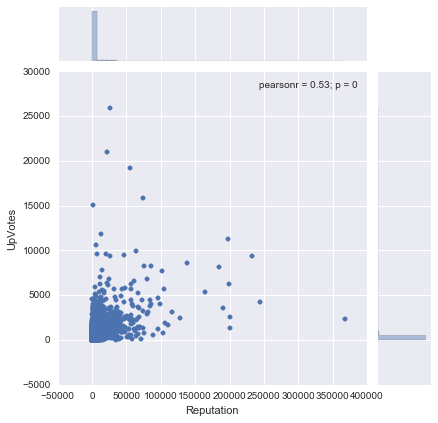

In [25]:
pandas_df = data.sample(False, .1, 42).toPandas()
# %matplotlib qt
sns.jointplot('Reputation', 'UpVotes', data=pandas_df)

Time taken = 0.981678962708 seconds.


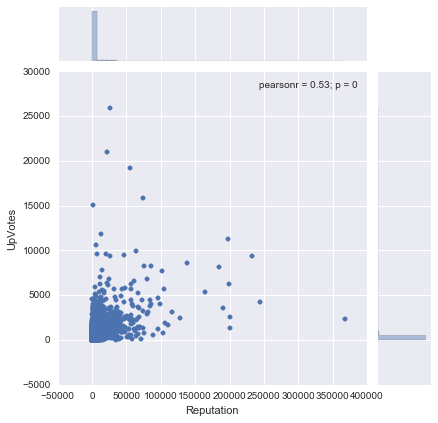

In [26]:
start_time = time()
pandas_df = data.sample(False, .1, 42).toPandas()
%matplotlib inline
sns.jointplot('Reputation', 'UpVotes', data=pandas_df)
print ("Time taken =", time() - start_time, "seconds.")

Time taken = 4.80216598511 seconds.


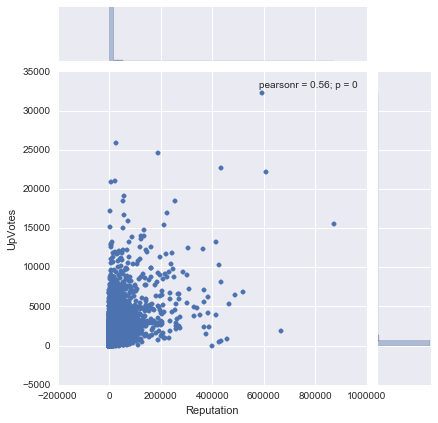

In [27]:
start_time = time()
pandas_df = data.sample(False, 0.9, 42).toPandas()
%matplotlib inline
sns.jointplot('Reputation', 'UpVotes', data=pandas_df)
print ("Time taken =", time() - start_time, "seconds.")

This visualistion is unintutive as most of the data is distributed in a narrow zone and the 
scale is skewed due to outliers. We will try plotting the values on the log scale.

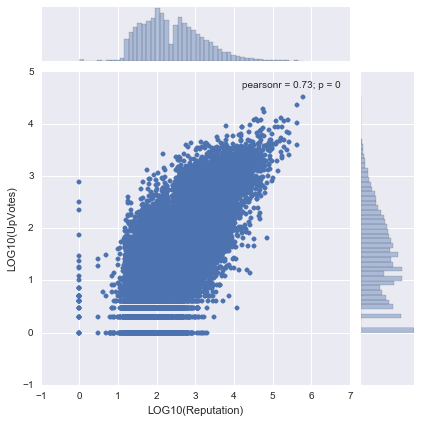

In [28]:
log_pandas_df = data.select(func.log10(data["Reputation"]),func.log10(data["UpVotes"])).sample(False, .1).toPandas()
# %matplotlib qt
sns.jointplot('LOG10(Reputation)', 'LOG10(UpVotes)', data=log_pandas_df)

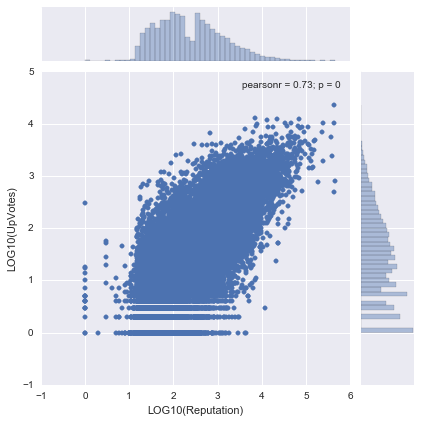

In [29]:
log_pandas_df = data.select(func.log10(data["Reputation"]),func.log10(data["UpVotes"])).sample(False, .1).toPandas()
%matplotlib inline
sns.jointplot('LOG10(Reputation)', 'LOG10(UpVotes)', data=log_pandas_df)

Before we wrap up, let us play with the *CreationDate* column and see if we can mine some interesting observations on that front. The idea is to show how we can play with more complex data types (like datetime) and use some Spark operators as well.

We will start with the *user_df* dataframe. Remember that we had uncached it which means it is no longer available in memory but we can still run operations on it. In this case, the dataframe would be loaded once again but will not be persisted, unless we explicitly ask Spark to do so.

In [30]:
creation_date_df = user_df.select("CreationDate")
creation_date_df.printSchema()
creation_date_df.show(10)

root
 |-- CreationDate: string (nullable = true)

+--------------------+
|        CreationDate|
+--------------------+
|2014-12-19T22:29:...|
|2014-12-19T22:30:...|
|2014-12-19T22:30:...|
|2014-12-19T22:30:...|
|2014-12-19T22:31:...|
|2014-12-19T22:31:...|
|2014-12-19T22:31:...|
|2014-12-19T22:32:...|
|2014-12-19T09:20:...|
|2014-12-19T22:32:...|
+--------------------+
only showing top 10 rows



Note that **CreationDate** column was parsed as **string**. Let us fix that by selecting **CreationDate** as **date** type.

In [31]:
date_df = creation_date_df.select(func.to_date(creation_date_df["CreationDate"]).alias("CreationDate"))
date_df.printSchema()
date_df.show(10)

root
 |-- CreationDate: date (nullable = true)

+------------+
|CreationDate|
+------------+
|  2014-12-19|
|  2014-12-19|
|  2014-12-19|
|  2014-12-19|
|  2014-12-19|
|  2014-12-19|
|  2014-12-19|
|  2014-12-19|
|  2014-12-19|
|  2014-12-19|
+------------+
only showing top 10 rows



### RDD vs DataFrame

We want to count the number of new accounts each day. We would try doing this using both RDDs and DataFrames and compare their performance.

### RDD
Convert dataframe to rdd.

Map each row with numerical value 1 (number of accounts each row contributes).

Then we reduce our data using date as the key and add the values corresponding to same date.

In [32]:
start_time = time()
date_rdd = date_df.rdd
aggregated_df = date_rdd.map(lambda a: (a, 1)).groupByKey().map(lambda a: (a[0], sum(a[1])))
print ("aggregated_df maps each date to number of accounts that were created.")
print ("Number of rows = ",aggregated_df.count())
time_taken_rdd = time() - start_time
print ("Time taken =", time_taken_rdd, "seconds.")

aggregated_df maps each date to number of accounts that were created.
Number of rows =  2874
Time taken = 23.8184030056 seconds.


### DataFrame

In [33]:
start_time = time()
aggregated_df = date_df.groupBy('CreationDate').count()
print ("aggregated_df maps each date to number of accounts that were created.")
print ("Number of rows = ",aggregated_df.count())
time_taken_df = time() - start_time
print ("Time taken =", time_taken_df, "seconds.")

aggregated_df maps each date to number of accounts that were created.
Number of rows =  2874
Time taken = 4.8155810833 seconds.


In [34]:
print ("time_taken_rdd =", time_taken_rdd)
print ("time_taken_df =", time_taken_df)
print ("Speed up =",time_taken_rdd/time_taken_df)

time_taken_rdd = 23.8184030056
time_taken_df = 4.8155810833
Speed up = 4.94611192161


### DataFrames are many times faster than RDDs.

In [35]:
aggregated_df.printSchema()

root
 |-- CreationDate: date (nullable = true)
 |-- count: long (nullable = false)



In [36]:
pandas_df = aggregated_df.select("CreationDate", aggregated_df["count"].alias("NewAccounts"))\
.orderBy(func.asc("CreationDate")).toPandas()
pandas_df

,CreationDate,NewAccounts
0,2008-07-31,9
1,2008-08-01,80
2,2008-08-02,54
3,2008-08-03,54
4,2008-08-04,83
5,2008-08-05,86
6,2008-08-06,89
7,2008-08-07,81
8,2008-08-08,66
9,2008-08-09,64


Let us plot this data and see if there is any interesting observation.

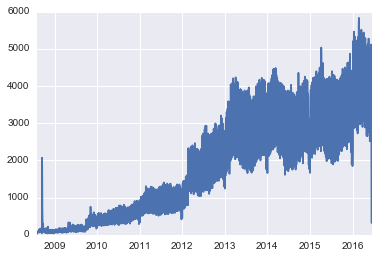

In [37]:
# %matplotlib qt
plt.plot(pandas_df.CreationDate, pandas_df.NewAccounts)

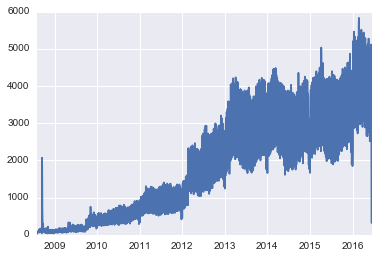

In [38]:
%matplotlib inline
plt.plot(pandas_df.CreationDate, pandas_df.NewAccounts)

Interesting! We can see a spike in the initial data. If we zoom in, we see the date of the spike as 15th September,2008 when over 2000 new users joined StackOverflow. Flipping the pages of history, this was the day when StackOverflow was opened for public.